# Модель для прогнозирования цен на электроэнергию в Европе

<p>Модель была реализована в 2020 г., предназначена для прогнозирования глобальной температуры воздуха на Земле.</p>
<p>В качестве входящих факторов использованы 3 показателя.</p>
<p>Модель была интегрирована в BI-систему, в которой входящие данные автоматически загружались из источников, предсказания модели пересчитывались и визуализировались.</p>
<p>Данный документ демонстрирует принципы построения ML-модели, не раскрывая методику, ссылки на использовавшиеся научные работы, данные и произведенные с ними преобразования.</p>

### Импорт библиотек

In [25]:
import pandas as pd
import numpy as np

from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import TimeSeriesSplit
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

from sklearn.metrics import mean_squared_error

from sklearn.linear_model import LinearRegression

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

import phik
from phik.report import plot_correlation_matrix

### Загрузка данных

In [26]:
# Загружаем данные из файлов
price = pd.read_csv('datasets/eu_wholesale_electr_price_average.csv', sep=';', decimal=',', names=['date', 'price'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')
df_1 = pd.read_csv('datasets/feature_1.csv', sep=';', decimal=',', names=['date', 'feature_1'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')
df_2 = pd.read_csv('datasets/feature_2.csv', sep=';', decimal=',', names=['date', 'feature_2'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')
df_3 = pd.read_csv('datasets/feature_3.csv', sep=';', decimal=',', names=['date', 'feature_3'], index_col=[0], parse_dates=[0], date_format='%d.%m.%Y')

### Описание данных

<ul>
    <li>price - средняя оптовая цена на электроэнергию в Европе (EUR/MWh).</li>
    <li>feature_1, feature_2, feature_3 - показатели, выбранные в качестве входящих признаков для модели (не раскрываются).</li>
</ul>

### Предобработка данных

In [27]:
# Функция для подсчета пропусков в столбцах датафрейма
def check_na(df):
    cols_na = pd.DataFrame(columns=['column','count'])
    for col in df.columns:
        print(col, df[col].isna().sum())

#### price

In [28]:
# Выведем информацию о полях датафрейма
price.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 95 entries, 2022-11-30 to 2015-01-31
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   price   95 non-null     float64
dtypes: float64(1)
memory usage: 1.5 KB


<p>Наименование столбца и тип данных корректны.</p>

In [29]:
# Проверим датафрейм на пропуски
check_na(price)

price 0


<p>Пропусков в данных не обнаружено.</p>

#### feature_1

In [30]:
# Выведем информацию о полях датафрейма
df_1.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162 entries, 2023-12-31 to 2010-03-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_1  162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


<p>Наименование столбца и тип данных корректны.</p>

In [31]:
# Проверим датафрейм на пропуски
check_na(df_1)

feature_1 0


<p>Пропусков в данных не обнаружено.</p>

#### feature_2

In [32]:
# Выведем информацию о полях датафрейма
df_2.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 162 entries, 2023-12-31 to 2010-01-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_2  162 non-null    float64
dtypes: float64(1)
memory usage: 2.5 KB


<p>Наименование столбца и тип данных корректны.</p>

In [33]:
# Проверим датафрейм на пропуски
check_na(df_2)

feature_2 0


<p>Пропусков в данных не обнаружено.</p>

#### feature_3

In [34]:
# Выведем информацию о полях датафрейма
df_3.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 215 entries, 2023-12-31 to 2005-05-31
Data columns (total 1 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   feature_3  215 non-null    float64
dtypes: float64(1)
memory usage: 3.4 KB


<p>Наименование столбца и тип данных корректны.</p>

In [35]:
# Проверим датафрейм на пропуски
check_na(df_3)

feature_3 0


<p>Пропусков в данных не обнаружено.</p>

### Исследовательский анализ

#### price

<p>Таргет - средняя оптовая цена на электроэнергию в Европе.</p>

In [36]:
price['price'].describe()

count     95.000000
mean      70.052105
std       70.891549
min       20.470000
25%       37.000000
50%       42.050000
75%       58.015000
max      414.680000
Name: price, dtype: float64

<p>Среднее значение 70.05, минимум 20.47, максимум 414.68.</p>
<p>Построим график с динамикой тиргета.</p>

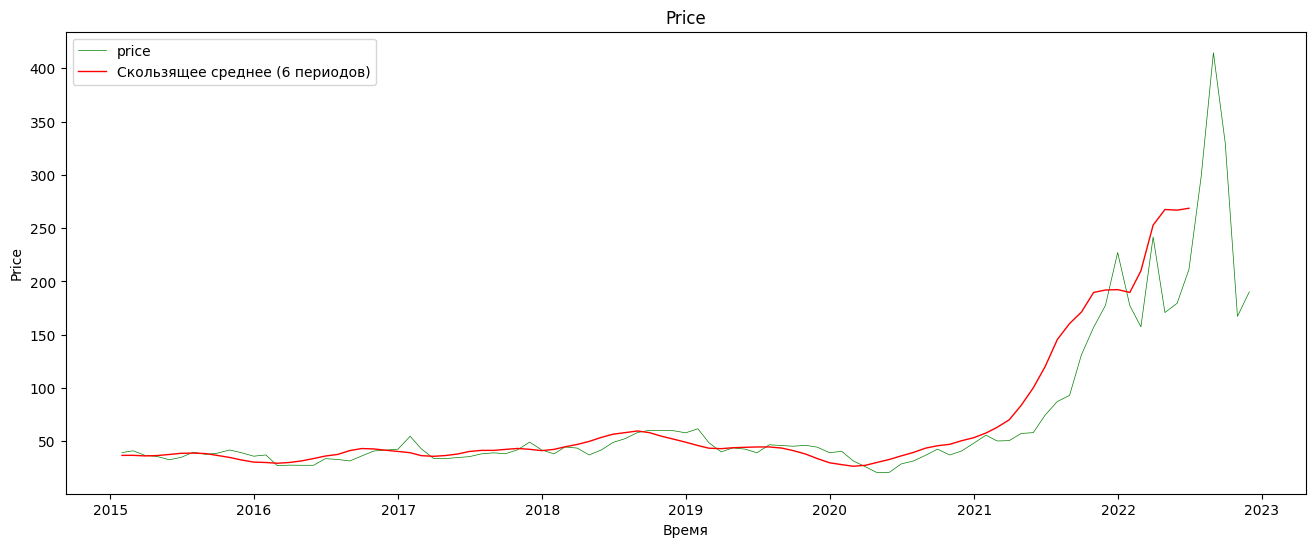

In [37]:
# Выведем график показателя
plt.figure(figsize=(16, 6))

# Скользящее среднее
rolling_mean_6 = price['price'].rolling(window=6).mean()

sns.lineplot(x=price.index, y=price['price'], label='price', color='green', lw=0.5).set(title='Price', xlabel='Время', ylabel='Price');
sns.lineplot(x=rolling_mean_6.index, y=rolling_mean_6, label='Скользящее среднее (6 периодов)', color='red', lw=1)

plt.show();

<p>На графике виден значительный рост показателя с 2021 г.</p>

### Объединение таблиц

In [38]:
# Объединим таблицы
data = pd.merge(price, df_1, on='date', how='inner')
data = pd.merge(data, df_2, on='date', how='inner')
data = pd.merge(data, df_3, on='date', how='inner')

In [39]:
# Проверим объединенный датафрейм на наличие пропусков
check_na(data)

price 0
feature_1 0
feature_2 0
feature_3 0


<p>Пропусков в данных не обнаружено.</p>

### Корреляционный анализ

<p>Проведем корреляционный анализ признаков для выявления мультиколлинеарности, а также признаков, в наибольшей степени влияющих на таргет.</p>

In [40]:
# Количественные признаки
numerical_cols = ['feature_1',
                  'feature_2',
                  'feature_3']

# Категорийные признаки
categorical_cols = []

# Таргет
target = ['price']

# Список признаков для проведения корреляционного анализц
phik_cols = target + numerical_cols + categorical_cols

In [41]:
# вычисление коэффициентов корреляции phi для датафрейма
phik_overview = data[phik_cols].phik_matrix(interval_cols=numerical_cols+target)

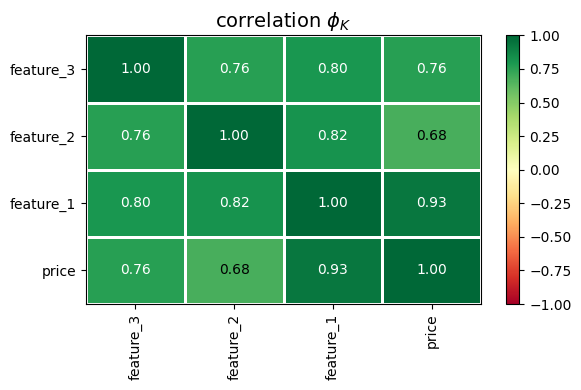

In [42]:
# визуализация тепловой карты коэффициентов корреляции
plot_correlation_matrix(
    phik_overview.values,
    x_labels=phik_overview.columns,
    y_labels=phik_overview.index,
    title=r"correlation $\phi_K$",
    fontsize_factor=1,
    figsize=(6, 4)
)

<p>Наибольшую корреляцию с таргетом имеют признаки:</p>
<ul>
    <li>feature_1</li>
    <li>feature_3</li>
</ul>
<p>Мультиколлинеарности среди признаков не наблюдается.</p>

### Разделение на выборки

In [49]:
# Дата начала тестовых данных
test_start_date = '2021-05-31'

data = data.sort_index()

# Отделяем обучающий период
train_df = data.loc[:test_start_date]

# Отделяем тестовый период
test_df = data.loc[test_start_date:]

# Формируем обучающую выборку
X_train = train_df.drop(columns=['price'])
y_train = train_df.price

# Формируем тестовую выборку
X_test = test_df.drop(columns=['price'])
y_test = test_df.price

print('Размер тестовой выборки:', round(len(X_test)/len(X_train),2))

Размер тестовой выборки: 0.25


### Создание пайплайна

<p>Все входные признаки являются числовыми. В пайплайне оставим только подготовку числовых признаков.</p>

In [50]:
# Создаём пайплайн для подготовки признаков из списка numerical_cols
num_pipe = Pipeline(
    [('simpleImputer_num', SimpleImputer(missing_values=np.nan, strategy='mean')),
     ('num', StandardScaler())
    ]
)

# Создаём общий пайплайн для подготовки данных с num
data_preprocessor = ColumnTransformer(
    [('num', num_pipe, numerical_cols)
    ], 
    remainder='passthrough'
)

In [51]:
# Инициализируем модель
pipe = Pipeline([
              ('preprocessor', data_preprocessor),
              ('model', LinearRegression())
             ])

# TimeSeriesSplit для кросс-валидации по временным рядам
tscv = TimeSeriesSplit(n_splits=3)

In [52]:
%%time

# Вычислим метрику mse на кросс-валидации
mse = -cross_val_score(pipe,
                       X_train,
                       y_train,
                       cv=tscv,
                       scoring='neg_mean_squared_error')

CPU times: user 37.2 ms, sys: 19.8 ms, total: 57 ms
Wall time: 103 ms


In [53]:
# Вычислим метрику rmse
rmse = np.sqrt(mse.mean())

# Выведем rmse модели на обучающих данных
print('RMSE модели: ', round(rmse, 2))

RMSE модели:  9.75


In [54]:
%%time

# Обучим модель на тренировочной выборке
pipe.fit(X_train, y_train)

CPU times: user 10.6 ms, sys: 1.82 ms, total: 12.4 ms
Wall time: 11.9 ms


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('num',
                                                  Pipeline(steps=[('simpleImputer_num',
                                                                   SimpleImputer()),
                                                                  ('num',
                                                                   StandardScaler())]),
                                                  ['feature_1', 'feature_2',
                                                   'feature_3'])])),
                ('model', LinearRegression())])

In [55]:
%%time

# Выполним предсказание на обучающей выборке
y_pred_train = pipe.predict(X_train)

# Выполним предсказание на тестовой выборке
y_pred_test = pipe.predict(X_test)

CPU times: user 12.8 ms, sys: 585 µs, total: 13.4 ms
Wall time: 13.1 ms


In [56]:
# Вычислим RMSE для тестовой выборки
rmse = np.sqrt(mean_squared_error(y_test, y_pred_test))

print("RMSE на тестовых данных:", round(rmse, 4))

RMSE на тестовых данных: 45.2192


### Оценка важности признаков

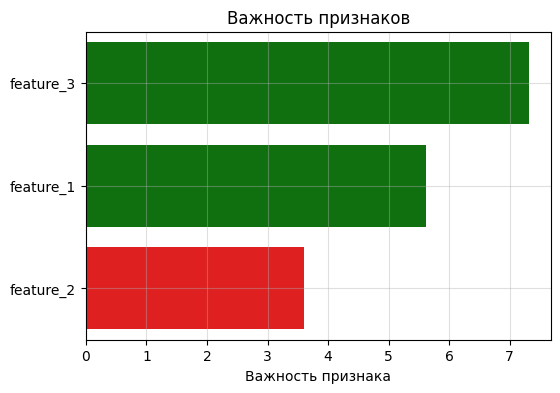

In [58]:
# Получим коэффициенты модели
coefficients = pipe.named_steps['model'].coef_

# Выведем важность признаков
feature_importances = dict(zip(X_train.columns, coefficients))
sorted_importances = sorted(feature_importances.items(), key=lambda x: abs(x[1]), reverse=True)

# Подготавим данные для графика
features, importances = zip(*sorted_importances)
colors = ['green' if imp > 0 else 'red' for imp in importances]
abs_importances = [abs(imp) for imp in importances]  # Получаем абсолютные значения

# Выведем график
plt.figure(figsize=(6, 4))
sns.barplot(x=abs_importances, y=features, hue=features, palette=colors, legend=False)
plt.xlabel('Важность признака')
plt.title('Важность признаков')
plt.grid(alpha=0.4)
plt.show()

<p>Наиболее важные признаки:</p>
<ul>
    <li>feature_3 - положительное влияние на таргет.</li>
    <li>feature_1 - положительное влияние.</li>
    <li>feature_2 - отрицательное влияние.</li>
</ul>

### Вывод графика модели

<p>Выведем график с динамикой таргета и предсказанием модели.</p>
<p>Учтем резкий рост таргета в 2021 г., в результате чего изменяется база при сравнении с величиной ошибки. Для устранения влияния эффекта базы выведем данные на графике с логарифмических масштабом по шакле y.</p>

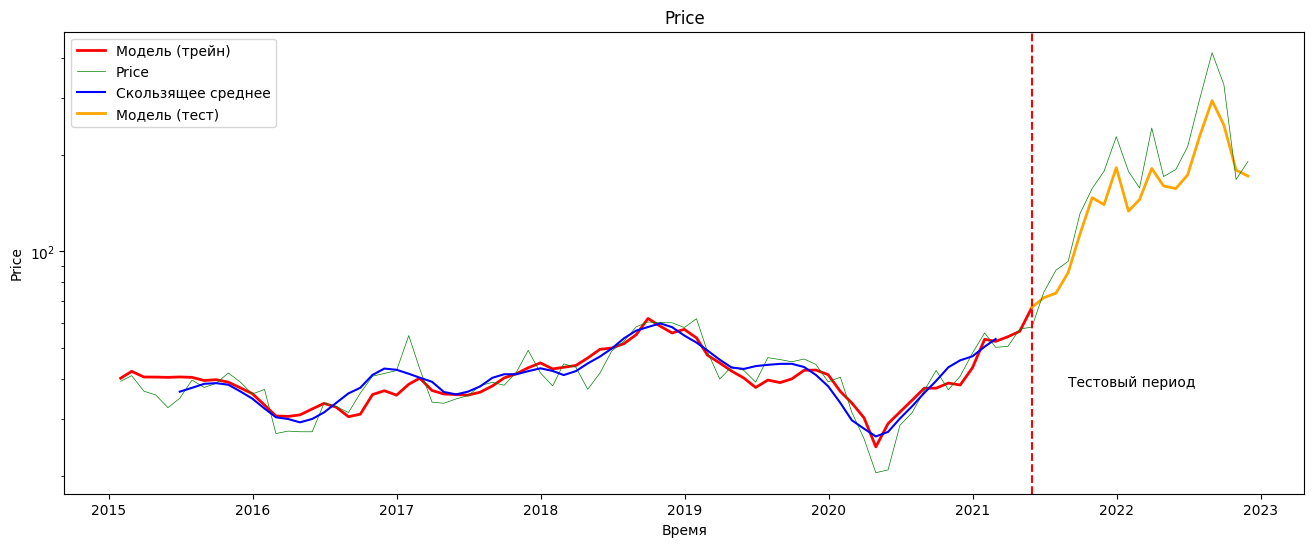

In [63]:
# Выведем график, демонстрирующий работу модели
plt.figure(figsize=(16, 6))

# Тренировочный период
sns.lineplot(y=y_pred_train, x=train_df.index, label='Модель (трейн)', color='red', lw=2).set(title='Price', xlabel='Время', ylabel='Price');
sns.lineplot(data=train_df['price'], label='Price', color='green', lw=0.5)

# Скользящее среднее
rolling_mean_train = train_df['price'].shift(periods=-3).rolling(window=6).mean()
sns.lineplot(x=rolling_mean_train.index, y=rolling_mean_train, label='Скользящее среднее', color='blue', lw=1.5)

# Тестовый период
sns.lineplot(y=y_pred_test, x=test_df.index, label='Модель (тест)', color='orange', lw=2).set(title='Price', xlabel='Время', ylabel='Price');
sns.lineplot(data=test_df['price'], color='green', lw=0.5)

plt.axvline(x=pd.to_datetime('2021-05-31'), color='red', linestyle='--')

plt.text(x=pd.to_datetime('2021-08-31'), y=test_df['price'].min()-20, s='Тестовый период', color='black')

# Установим логарифмический масштаб по оси Y
plt.gca().set_yscale('log')

plt.show();

<p>На графике видно, что модель хорошо объясняет среднее значение таргета.</p>
<p>Вычислим корреляцию между скользящим средим значением таргета и предсказанным значением на трейне.</p>

In [61]:
# Преобразуем y_pred_train в Series
y_pred_train_series = pd.Series(y_pred_train, index=train_df.index)

# Рассчитаем корреляцию
correlation = round(rolling_mean_train.corr(y_pred_train_series), 2)

print(f"Корреляция между скользящим средним и предсказаниями модели: {correlation}")

Корреляция между скользящим средним и предсказаниями модели: 0.93


## Выводы

<p>В ходе работы над моделью были выполнены следующие действия:</p>
<ul>
    <li>Загружены необходимые библиотеки.</li>
    <li>Загружены данных из csv-файлов.</li>
    <li>Проведена предобработка данных: проведена проверка на пропуски, корретность типов данных.</li>
    <li>Проведен исследовательский анализ таргета.</li>
    <li>Произведено объединение таблиц.</li>
    <li>Проведен корреляционный анализ признаков. Выявлены признаки с наибольшей корреляцией с таргетом, проведена проверка признаков на мультиколлинеарность (мультиколлинеарность не обнаружена).</li>
    <li>Произведено разделение данных на обучающую и тестовую выборки.</li>
    <li>Создан пайплайн.</li>
    <li>Вычислено значение метрики RMSE на кросс-валидации на обучающей выборке. Метрика RMSE равна 9,75.</li>
    <li>Обученная модель проверена на тестовой выборке. Метрика RMSE равна 45,22.</li>
    <li>Произведена оценка важности признаков. Наиболее важны признаки: feature_3 и feature_1.</li>
    <li>Выведен график модели с добавлением скользящего среднего таргета (6 периодов).</li>
    <li>Вычислен коэффициент корреляции Пирсона между предсказанными значениями на тестовом периоде и скользящим средним. <b>Значение r2 равно 0.93</b> (очень сильная зависимость).</li>
</ul>

## Общий вывод по модели

<p>Анализ результатов модели говорит о ее практической применимости для предсказания среднесрочных при прогнозировании средних оптовых цен на электроэнергию в Европе.</p>